# Cancer Tissue Detection using CNN


#### Installing Required libraries

### Step 1.1- Please refer to the "Technical Requirements" section in the book for the neccessary packages to be installed. Please note that chapter has differnt Pytorch Lightning version and thus diff torch dependancies. Some functions may not work with other versions than what is tested below, so please ensure correct versions.


In [1]:
#Step1 Please refer to the "Technical Requirements" section in the book for the neccessary packages to be installed here
!pip install pytorch-lightning==1.6.2 --quiet
!pip install torch==1.11.0 --quiet


     |████████████████████████████████| 582 kB 4.4 MB/s 
     |████████████████████████████████| 136 kB 34.9 MB/s 
     |████████████████████████████████| 596 kB 36.5 MB/s 
     |████████████████████████████████| 408 kB 34.2 MB/s 
     |████████████████████████████████| 1.1 MB 21.1 MB/s 
     |████████████████████████████████| 144 kB 15.9 MB/s 
     |████████████████████████████████| 271 kB 34.9 MB/s 
     |████████████████████████████████| 94 kB 1.8 MB/s 


In [2]:
!pip install opendatasets --upgrade --quiet

## **Step 1.2 Import the neccessary packages. Please refer to the section, Importing the packages in the book for further details. **

In [3]:
# !pip install torchtext==0.9.0

In [4]:
# !pip install pytorch==1.10

In [20]:
#refer to book for correct version of package and import here
import os
import shutil
import opendatasets as od
import pandas as pd
import numpy as np
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy
# from image_classifier import CNNImageClassifier

import pytorch_lightning as pl

In [6]:
print("pandas version:",pd.__version__)
print("numpy version:",np.__version__)
#print("seaborn version:",sns.__version__)
print("torch version:",torch.__version__)
print("pytorch ligthening version:",pl.__version__)



pandas version: 1.3.5
numpy version: 1.21.6
torch version: 1.11.0+cu113
pytorch ligthening version: 1.6.2


# **Step 2.1 - Load the dataset- Please refer to the book in section "collecting the dataset" for the proper way to collect the dataset and steps to import it. **

In [7]:
#refer to section "Collecting the dataset and copy code here "
dataset_url = 'https://www.kaggle.com/c/histopathologic-cancer-detection'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rajsolanki23
Your Kaggle Key: ··········


100%|██████████| 6.31G/6.31G [02:13<00:00, 50.9MB/s]



Extracting archive ./histopathologic-cancer-detection/histopathologic-cancer-detection.zip to ./histopathologic-cancer-detection


There is a separate csv file which contains only the labels. Let's read the dataset and see the head of the dataframe in pandas

In [8]:
df_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
df_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [9]:
df_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

There are 130908 normal cases (0) and and 89117 abnormal (cancerous) cases (1) 

*   List item
*   List item

which is not highly unbalanced. 

In [10]:
print('No. of images in training dataset: ', len(os.listdir("histopathologic-cancer-detection/train")))
print('No. of images in testing dataset: ', len(os.listdir("histopathologic-cancer-detection/test")))

No. of images in training dataset:  220025
No. of images in testing dataset:  57458


This is a huge dataset which requires a lot of compute time and resources so for the purpose of learning our first basic image classification model, we will downsample it to 5000 images and then split it into training and testing dataset.

In [11]:
# Setting seed to make the results replicable
np.random.seed(0)
train_imgs_orig = os.listdir("histopathologic-cancer-detection/train")
selected_image_list = []
for img in np.random.choice(train_imgs_orig, 10000):
  selected_image_list.append(img)
len(selected_image_list)

10000

In [12]:
selected_image_list[0]

'2c110f5021b1c1fdc89bb4e6fe7c2c901f7b9513.tif'

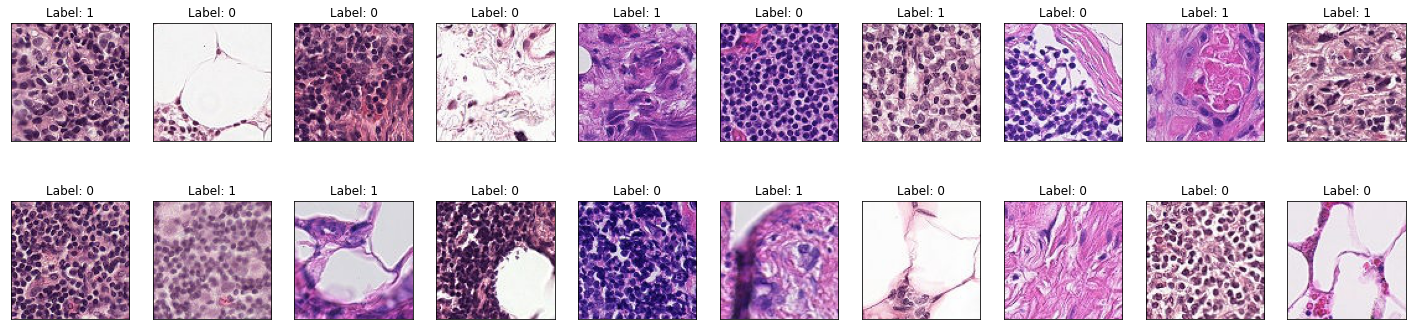

In [13]:
fig = plt.figure(figsize=(25, 6))
for idx, img in enumerate(np.random.choice(selected_image_list, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)
    lab = df_labels.loc[df_labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [14]:
np.random.seed(0)
np.random.shuffle(selected_image_list)
train_idx = selected_image_list[:8000]
test_idx = selected_image_list[8000:]
print("Number of images in the downsampled training dataset: ", len(train_idx))
print("Number of images in the downsampled testing dataset: ", len(test_idx))

Number of images in the downsampled training dataset:  8000
Number of images in the downsampled testing dataset:  2000


### Processing the dataset
The following information has been provided on the Kaggle and the Github where the dataset is hosted - "A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable the design of fully-convolutional models that do not use any zero-padding, to ensure consistent behavior when applied to a whole-slide image."

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [16]:
#os.mkdir('/content/histopathologic-cancer-detection/train_dataset/')

In [17]:
os.mkdir('/content/histopathologic-cancer-detection/test_dataset/')
for fname in test_idx:
  src = os.path.join('histopathologic-cancer-detection/train', fname)
  dst = os.path.join('/content/histopathologic-cancer-detection/test_dataset/', fname)
  shutil.copyfile(src, dst)
print('No. of images in downsampled testing dataset: ', len(os.listdir("/content/histopathologic-cancer-detection/test_dataset/")))

No. of images in downsampled testing dataset:  1989


In [18]:
os.mkdir('/content/histopathologic-cancer-detection/train_dataset/')
for fname in train_idx:
  src = os.path.join('histopathologic-cancer-detection/train', fname)
  dst = os.path.join('/content/histopathologic-cancer-detection/train_dataset/', fname)
  shutil.copyfile(src, dst)
print('No. of images in downsampled training dataset: ', len(os.listdir("/content/histopathologic-cancer-detection/train_dataset/")))


No. of images in downsampled training dataset:  7847


In [21]:
data_T_train = T.Compose([
    T.CenterCrop(32),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    ])
data_T_test = T.Compose([
    T.CenterCrop(32),
    T.ToTensor(),
    ])

In [22]:
# Extracting the labels for the images that were selected in the downsampled data
selected_image_labels = pd.DataFrame()
id_list = []
label_list = []

for img in selected_image_list:
  label_tuple = df_labels.loc[df_labels['id'] == img.split('.')[0]]
  id_list.append(label_tuple['id'].values[0])
  label_list.append(label_tuple['label'].values[0])

In [23]:
selected_image_labels['id'] = id_list
selected_image_labels['label'] = label_list
selected_image_labels.head()

,id,label
0,271c3a0286c830236a7d77f9924c679a3e3a4be4,0
1,a2d9800e3df4eec061a40bb70274118354fa7cb8,0
2,14fff01bb0a6b5c82acc5377f9b34a80da9b71e0,1
3,219b0bbd898526261fc3e9eebece90e3d26060f2,0
4,4d88b75c62af81deff522c29dd72f1377f782baf,1


In [24]:
# dictionary with labels and ids of train data
img_label_dict = {k:v for k, v in zip(selected_image_labels.id, selected_image_labels.label)}

Pytorch lightning expects data to be in folders with the classes. We cannot use the DataLoader module directly when all train images are in one folder without subfolders. So, we will write our custom function to carry out the loading. 


In [25]:
class LoadCancerDataset(Dataset):
    def __init__(self, data_folder, 
                 transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), dict_labels={}):
        self.data_folder = data_folder
        self.list_image_files = [s for s in os.listdir(data_folder)]
        self.transform = transform
        self.dict_labels = dict_labels
        self.labels = [dict_labels[i.split('.')[0]] for i in self.list_image_files]

    def __len__(self):
        return len(self.list_image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.list_image_files[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.list_image_files[idx].split('.')[0]

        label = self.dict_labels[img_name_short]
        return image, label

In [26]:
%%time
# Load train data 
train_set = LoadCancerDataset(data_folder='/content/histopathologic-cancer-detection/train_dataset/', 
                        # datatype='train', 
                        transform=data_T_train, dict_labels=img_label_dict)

CPU times: user 14.3 ms, sys: 2.05 ms, total: 16.4 ms
Wall time: 19.7 ms


In [27]:
test_set = LoadCancerDataset(data_folder='/content/histopathologic-cancer-detection/test_dataset/', 
                         transform=data_T_test, dict_labels=img_label_dict)


In [28]:
batch_size = 256

train_dataloader = DataLoader(train_set, batch_size, num_workers=2, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size, num_workers=2, pin_memory=True)

In [29]:
class CNNImageClassifier(pl.LightningModule):

    def __init__(self, learning_rate = 0.001):
        super().__init__()

        self.learning_rate = learning_rate

        self.conv_layer1 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv_layer2 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.fully_connected_1 =nn.Linear(in_features=16 * 16 * 6,out_features=1000)
        self.fully_connected_2 =nn.Linear(in_features=1000,out_features=500)
        self.fully_connected_3 =nn.Linear(in_features=500,out_features=250)
        self.fully_connected_4 =nn.Linear(in_features=250,out_features=120)
        self.fully_connected_5 =nn.Linear(in_features=120,out_features=60)
        self.fully_connected_6 =nn.Linear(in_features=60,out_features=2)
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters()

    def forward(self, input):
        output=self.conv_layer1(input)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv_layer2(output)
        output=self.relu2(output)
        output=output.view(-1, 6*16*16)
        output = self.fully_connected_1(output)
        output = self.fully_connected_2(output)
        output = self.fully_connected_3(output)
        output = self.fully_connected_4(output)
        output = self.fully_connected_5(output)
        output = self.fully_connected_6(output)
        return output

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs) 
        train_accuracy = accuracy(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('train_accuracy', train_accuracy, prog_bar=True)
        self.log('train_loss', loss)
        return {"loss":loss, "train_accuracy":train_accuracy}

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        test_accuracy = accuracy(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('test_accuracy', test_accuracy)
        return {"test_loss":loss, "test_accuracy":test_accuracy}

    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.Adam(params=params, lr = self.learning_rate)
        return optimizer

    # Calculate accuracy for each batch at a time
    def binary_accuracy(self, outputs, targets):
        _, outputs = torch.max(outputs,1)
        correct_results_sum = (outputs == targets).sum().float()
        acc = correct_results_sum/targets.shape[0]
        return acc

    def predict_step(self, batch, batch_idx ):
        return self(batch)

In [30]:
model = CNNImageClassifier()

trainer = pl.Trainer(fast_dev_run=True, gpus=1)
trainer.fit(model, train_dataloaders=train_dataloader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name              | Type             | Params
-----------

Training: 0it [00:00, ?it/s]

In [31]:
ckpt_dir = "/content/gdrive/MyDrive/Colab Notebooks/cnn"
ckpt_callback = pl.callbacks.ModelCheckpoint(every_n_epochs=25)

model = CNNImageClassifier()
trainer = pl.Trainer(
    default_root_dir=ckpt_dir,
                     gpus=-1,
                    #  progress_bar_refresh_rate=30,
                        callbacks=[ckpt_callback],
                        log_every_n_steps=25,
                        max_epochs=500)
trainer.fit(model, train_dataloaders=train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/gdrive/MyDrive/Colab Notebooks/cnn/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name              | Type             | Params
--------------------------------------------------------
0  | conv_layer1       | Conv2d           | 84    
1  | relu1             | ReLU             | 0     
2  | pool              | MaxPool2d        | 0     
3  | conv_layer2       | Conv2d           | 168   
4  | relu2             | ReLU             | 0     
5  | fully_connected_1 | Linear           | 1.5 M 
6  | fully_connected_2 | Linear           | 500 K 
7  | fully_connected_3 | Linear           | 125 K 
8  | fully_connected_4 | Linear           | 30.1 K
9  | fully_connected_5 | Linear           | 7.3 K 
10 | fully_connected_6 | Linear           | 122   
11 | loss              | CrossEntropyLoss | 0     
----------

Training: 0it [00:00, ?it/s]

In [41]:
trainer.test(dataloaders=test_dataloader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1445: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /content/gdrive/MyDrive/Colab Notebooks/cnn/lightning_logs/version_0/checkpoints/epoch=499-step=15500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/gdrive/MyDrive/Colab Notebooks/cnn/lightning_logs/version_0/checkpoints/epoch=499-step=15500.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.7898441553115845
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy': 0.7898441553115845}]

In [42]:
model.eval()
preds = []
for batch_i, (data, target) in enumerate(test_dataloader):
    data, target = data.cuda(), target.cuda()
    output = model.cuda()(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

In [43]:
test_preds = pd.DataFrame({'imgs': test_set.list_image_files, 'labels':test_set.labels,  'preds': preds})


In [44]:
test_preds['imgs'] = test_preds['imgs'].apply(lambda x: x.split('.')[0])


In [45]:
test_preds.head()

,imgs,labels,preds
0,f002a1ccea4142923c4fe66d96a51ecedea4b046,1,0.501024
1,a2f3c3e770eb15e29f024d3e5926dccfa5b20dd1,0,-0.371648
2,553460633b1df2c2f972e95aadec860188d2e0a7,0,-0.250726
3,f58c11e382458151fd8f5a9763cac935dc6bca8e,0,-1.073601
4,f82c14d53c38b1af78af8ebcb11d6e0df5f9eafe,0,-0.840947


In [46]:
test_preds['predictions'] = 1
test_preds.loc[test_preds['preds'] < 0, 'predictions'] = 0
test_preds.shape

(1989, 4)

In [47]:
test_preds.head()

,imgs,labels,preds,predictions
0,f002a1ccea4142923c4fe66d96a51ecedea4b046,1,0.501024,1
1,a2f3c3e770eb15e29f024d3e5926dccfa5b20dd1,0,-0.371648,0
2,553460633b1df2c2f972e95aadec860188d2e0a7,0,-0.250726,0
3,f58c11e382458151fd8f5a9763cac935dc6bca8e,0,-1.073601,0
4,f82c14d53c38b1af78af8ebcb11d6e0df5f9eafe,0,-0.840947,0


In [48]:
len(np.where(test_preds['labels'] == test_preds['predictions'])[0])/test_preds.shape[0]

0.7873303167420814